##Detecting Retinopathy through Blob Detection
I think we need to slightly modify our approach: it would be nice if we could recognize the blotch
es of deformed blood vessels/aneurisms/blood stains as blobs/corners on the image and extract features this way. 

###Auxilary Function to Show Images

In [1]:
%matplotlib inline

from matplotlib import pyplot as plt
from skimage import data
from skimage.feature import blob_dog, blob_log, blob_doh
from math import sqrt
from skimage.color import rgb2gray
from skimage import io
from os import path
import numpy as np
from skimage import io
from scipy.ndimage.filters import gaussian_filter

def show_images(images,titles=None):
    """Display a list of images"""
    n_ims = len(images)
    if titles is None: titles = ['(%d)' % i for i in range(1,n_ims + 1)]
    fig = plt.figure()
    n = 1
    for image,title in zip(images,titles):
        a = fig.add_subplot(1,n_ims,n) # Make subplot
        if image.ndim == 2: # Is image grayscale?
            plt.gray() # Only place in this blog you can't replace 'gray' with 'grey'
        plt.imshow(image)
        a.set_title(title)
        n += 1
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_ims)
    plt.show()
    


###Load an image, do some processing on it and show

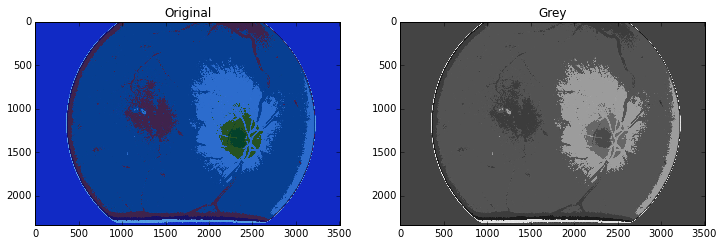

In [2]:
from skimage.exposure import equalize_hist, equalize_adapthist
inp_path ='/users/boris/Dropbox/Shared/Retina/coldMap_gaussBlur'
#inp_file = '4/1350_left.jpeg'
inp_file = '4/1350_left.jpeg'

image = io.imread(path.join(inp_path, inp_file))
image_gray = rgb2gray(image)
 
red, green, blue = image.copy(), image.copy(), image.copy()
red[:, :, (1, 2)] = 0
green[:, :, (0, 2)] = 0
blue[:, :, (0, 1)] = 0

show_images(images=[image, image_gray], titles=['Original', 'Grey'])
#show_images(images=[red, green, blue], titles=['Red', 'Green', 'Blue'])

In [5]:
equalized_adaptive_image = equalize_adapthist(image_gray, ntiles_x=16, ntiles_y=16, clip_limit=0.5)

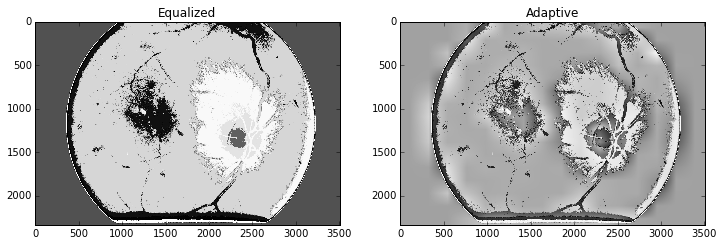

In [6]:
equalized_image = equalize_hist(image_gray)
show_images(images = [equalized_image, equalized_adaptive_image], titles=["Equalized", "Adaptive"])
#equalized_adaptive_image_rgb = equalize_adapthist(image, ntiles_x=16, ntiles_y=16, nbins=2)
#show_images(images=[equalized_adaptive_image_rgb], titles=["CLAHE rgb"])

###Detecting blobs with different image normalizations (not doing red, green, or blue)

In [7]:
#image = data.hubble_deep_field()[0:500, 0:500]
def do_blobs(image_gray, image):
    blobs_log = blob_log(image_gray, max_sigma=30, num_sigma=10, threshold=.1)
    # Compute radii in the 3rd column.
    blobs_log[blobs_log[:, 2] <= 2] = blobs_log[blobs_log[:, 2] <= 2] * sqrt(2)

    blobs_dog = blob_dog(image_gray, max_sigma=30, threshold=.5)
    blobs_dog[blobs_dog[:, 2] <= 2] = blobs_dog[blobs_dog[:, 2] <= 2] * sqrt(2)

    blobs_list = [blobs_log, blobs_dog]
    colors = ['yellow', 'lime']
    titles = ['Laplacian of Gaussian', 'Difference of Gaussian']
    sequence = zip(blobs_list, colors, titles)

    for blobs, color, title in sequence:
        fig, ax = plt.subplots(1, 1)
        ax.set_title(title)
        ax.imshow(image, interpolation='nearest')
        for blob in blobs:
            y, x, r = blob
            c = plt.Circle((x, y), r, color=color, linewidth=2, fill=False)
            ax.add_patch(c)

    plt.show()

In [ ]:
print "Histogram equalization"
do_blobs(equalized_image, image)

Simple greyscale


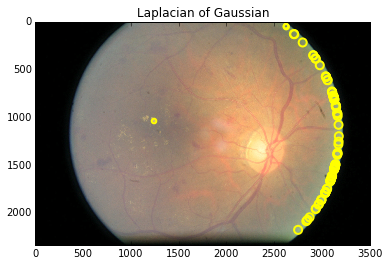

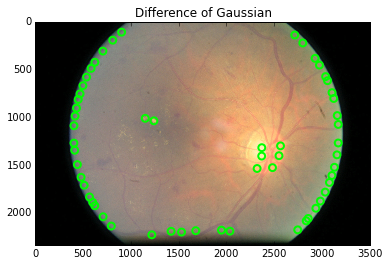

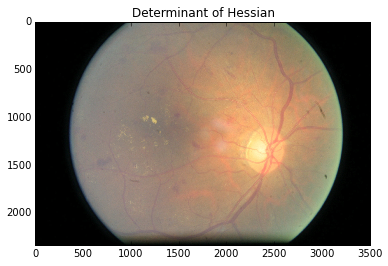

Histogram equalization


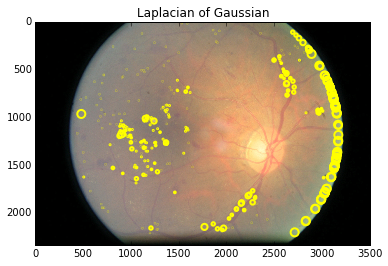

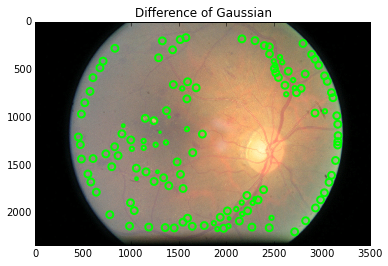

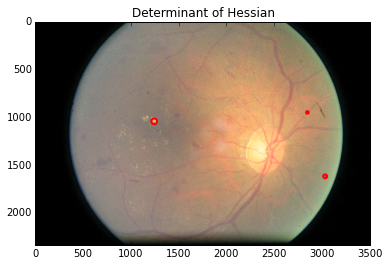

Adaptive histogram equalization


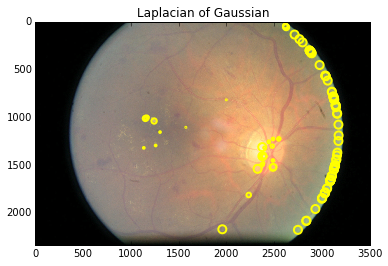

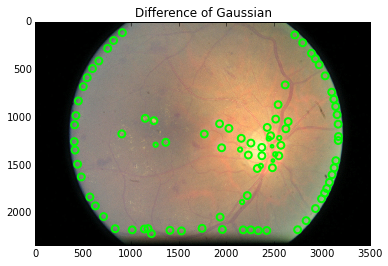

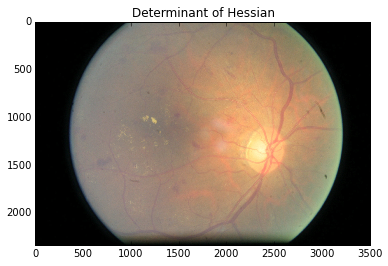

In [7]:
print "Simple greyscale"
do_blobs(image_gray, image)
print "Histogram equalization"
do_blobs(equalized_image, image)
print "Adaptive histogram equalization"
do_blobs(equalized_adaptive_image, image)

###Detecting corners

In [17]:
from skimage.feature import corner_harris,corner_peaks

# More pyplot!
def show_corners(corners,image,title=None):
    """Display a list of corners overlapping an image"""
    fig = plt.figure()
    plt.imshow(image)
    # Convert coordinates to x and y lists
    y_corner,x_corner = zip(*corners)
    plt.plot(x_corner,y_corner,'o') # Plot corners
    if title:
        plt.title(title)
    plt.xlim(0,image.shape[1])
    plt.ylim(image.shape[0],0) # Images use weird axes
    fig.set_size_inches(np.array(fig.get_size_inches()) * 1.5)
    plt.show()
    print "Number of corners:",len(corners)



Gray


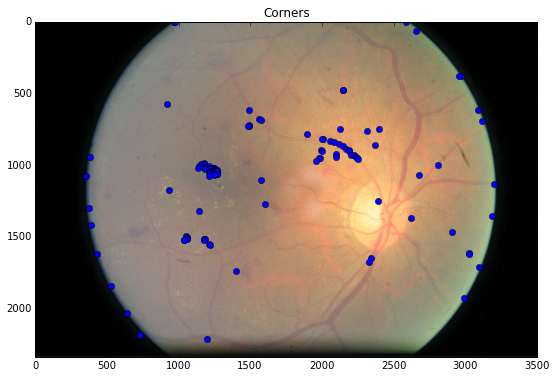

Number of corners: 116
Equalized


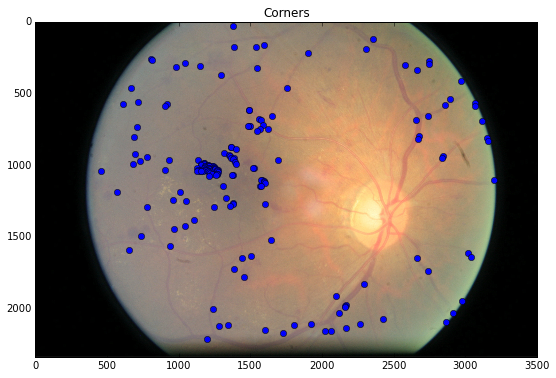

Number of corners: 179
Adaptive


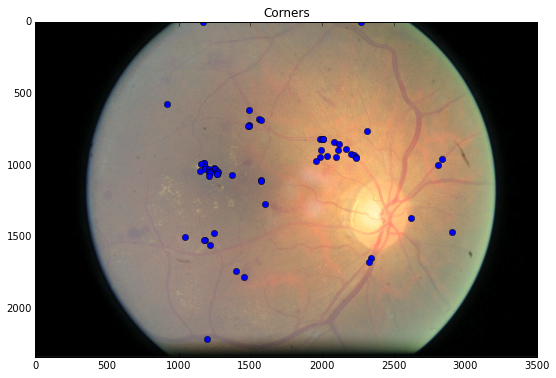

Number of corners: 63


In [18]:
print "Gray"
corners = corner_peaks(corner_harris(image_gray), min_distance=2)
show_corners(corners, image, title= "Corners")
print "Equalized"
corners = corner_peaks(corner_harris(equalized_image), min_distance=2)
show_corners(corners, image, title= "Corners")
print "Adaptive"
corners = corner_peaks(corner_harris(equalized_adaptive_image), min_distance=2)
show_corners(corners, image, title= "Corners")

Greyscale


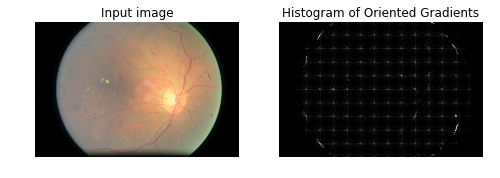

Equalized Histogram


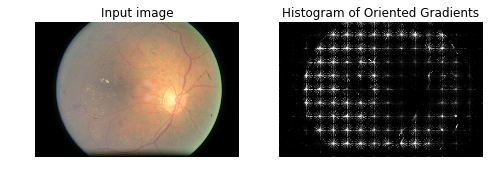

Adaptive Histogram


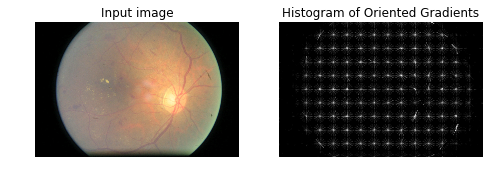

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

from skimage.feature import hog
from skimage import data, color, exposure

def do_hog(image_gray, image):
    fd, hog_image = hog(image_gray, orientations=8, pixels_per_cell=(16, 16),
                        cells_per_block=(1, 1), visualise=True)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

    ax1.axis('off')
    ax1.imshow(image, cmap=plt.cm.gray)
    ax1.set_title('Input image')

    # Rescale histogram for better display
    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 0.02))

    ax2.axis('off')
    ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
    ax2.set_title('Histogram of Oriented Gradients')
    plt.show()

print "Greyscale"
do_hog(image_gray, image)
print "Equalized Histogram"
do_hog(equalized_image, image)
print "Adaptive Histogram"
do_hog(equalized_adaptive_image, image)